In [1]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,classification_report
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas

In [2]:
# CHOOSE DATASET

# Regression dataset
data = datasets.load_diabetes(as_frame=True)

X = data.data.values
y = data.target.values 
X.shape

(442, 10)

In [3]:
#train test spliting
test_size=0.2
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=42)

In [4]:
# Standardize features
scaler=StandardScaler()
Xtr= scaler.fit_transform(Xtr)
Xte= scaler.transform(Xte)

In [5]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size=1, dropout_prob=0.5):
        super(MLP, self).__init__()
        
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 64)
        self.out = nn.Linear(64, output_size)
        
        self.dropout = nn.Dropout(p=dropout_prob)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        
        x = self.out(x)
        return x

In [6]:
num_epochs=100
lr=0.0003
dropout=0.2
batch_size=64

In [7]:
Xtr = torch.tensor(Xtr, dtype=torch.float32)
ytr = torch.tensor(ytr, dtype=torch.float32)
Xte = torch.tensor(Xte, dtype=torch.float32)
yte = torch.tensor(yte, dtype=torch.float32)

# Wrap Xtr and ytr into a dataset
train_dataset = TensorDataset(Xtr, ytr)

# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [8]:
# Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLP(input_size=Xtr.shape[1], dropout_prob=dropout).to(device)
criterion = nn.MSELoss() #for regression
optimizer = optim.Adam(model.parameters(), lr=lr)

In [9]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for batch_x, batch_y in train_dataloader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        logits = model(batch_x)
        loss = criterion(logits, batch_y.view(-1, 1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/100], Loss: 29449.1361
Epoch [2/100], Loss: 29537.6800
Epoch [3/100], Loss: 29648.5999
Epoch [4/100], Loss: 29870.2096
Epoch [5/100], Loss: 29251.0381
Epoch [6/100], Loss: 30329.8714
Epoch [7/100], Loss: 29287.1097
Epoch [8/100], Loss: 29474.9590
Epoch [9/100], Loss: 29603.8398
Epoch [10/100], Loss: 29241.7132
Epoch [11/100], Loss: 28707.5954
Epoch [12/100], Loss: 29675.3825
Epoch [13/100], Loss: 28270.2565
Epoch [14/100], Loss: 28059.0911
Epoch [15/100], Loss: 27659.1338
Epoch [16/100], Loss: 27542.0452
Epoch [17/100], Loss: 25897.6979
Epoch [18/100], Loss: 24763.1361
Epoch [19/100], Loss: 23212.8646
Epoch [20/100], Loss: 21354.4956
Epoch [21/100], Loss: 18705.7349
Epoch [22/100], Loss: 16359.4538
Epoch [23/100], Loss: 13653.5404
Epoch [24/100], Loss: 11158.1305
Epoch [25/100], Loss: 8903.7935
Epoch [26/100], Loss: 7219.4086
Epoch [27/100], Loss: 6266.7198
Epoch [28/100], Loss: 6350.3012
Epoch [29/100], Loss: 5513.2728
Epoch [30/100], Loss: 5502.0420
Epoch [31/100], Loss: 493

In [10]:
y_pred=model(Xte)
print(f'MSE:{mean_squared_error(yte.detach().numpy(),y_pred.detach().numpy())}') #regression

MSE:3743.030517578125


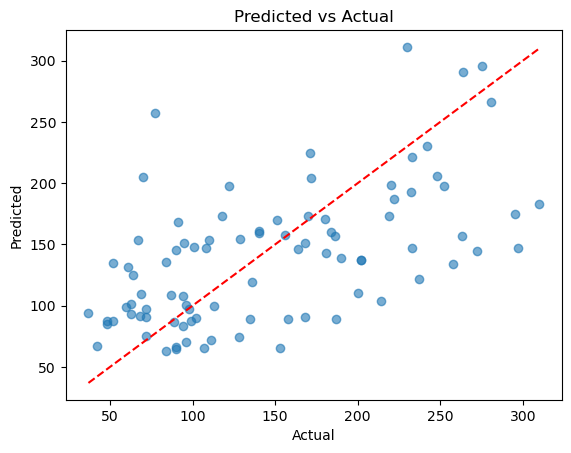

<Figure size 640x480 with 0 Axes>

In [11]:
plt.scatter(yte, y_pred.detach().numpy(), alpha=0.6)
plt.plot([yte.min(), yte.max()], [yte.min(), yte.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual")
plt.show()
plt.savefig("../Plots/PredictedActualMLP.pdf", format="pdf", bbox_inches="tight")